In [1]:
import pandas as pd
from datetime import datetime

import sns

In [2]:
# DATASET 1 PRE_PROCESSING
df_1_24 = pd.read_csv('merged_futbin_player_data_1_to_24.csv')
df_1_24.head()

new_columns = [
    'card_id', 'date', 'price', 'name', 'id', 'version', 'rating', 'foot',
    'skill_moves', 'weak_foot', 'pace_m', 'acceleration', 'sprint_speed',
    'shooting_m', 'att_position', 'finishing', 'shot_power', 'long_shots',
    'volleys', 'penalties', 'passing_m', 'vision', 'crossing', 'fk_acc',
    'short_pass', 'long_pass', 'curve', 'dribbling_m', 'agility', 'balance',
    'reactions', 'ball_control', 'dribbling', 'composure', 'defending_m',
    'interceptions', 'heading_acc', 'def_aware', 'stand_tackle', 'slide_tackle',
    'physical_m', 'jumping', 'stamina', 'strength', 'aggression', 'height',
    'weight', 'total_ingame_stats', 'card_page_url', 'nation', 'league', 'club', 'intl_rep'
]
df_1_24.columns = new_columns

df_1_24 = df_1_24.drop('name', axis=1)
df_1_24 = df_1_24.drop('id', axis=1)
df_1_24 = df_1_24.drop('version', axis=1)
df_1_24 = df_1_24.drop('foot', axis=1)
df_1_24 = df_1_24.drop('acceleration', axis=1)
df_1_24 = df_1_24.drop('sprint_speed', axis=1)
df_1_24 = df_1_24.drop('att_position', axis=1)
df_1_24 = df_1_24.drop('finishing', axis=1)
df_1_24 = df_1_24.drop('shot_power', axis=1)
df_1_24 = df_1_24.drop('long_shots', axis=1)
df_1_24 = df_1_24.drop('volleys', axis=1)
df_1_24 = df_1_24.drop('penalties', axis=1)
df_1_24 = df_1_24.drop('vision', axis=1)
df_1_24 = df_1_24.drop('crossing', axis=1)
df_1_24 = df_1_24.drop('fk_acc', axis=1)
df_1_24 = df_1_24.drop('short_pass', axis=1)
df_1_24 = df_1_24.drop('long_pass', axis=1)
df_1_24 = df_1_24.drop('curve', axis=1)
df_1_24 = df_1_24.drop('agility', axis=1)
df_1_24 = df_1_24.drop('balance', axis=1)
df_1_24 = df_1_24.drop('reactions', axis=1)
df_1_24 = df_1_24.drop('ball_control', axis=1)
df_1_24 = df_1_24.drop('dribbling', axis=1)
df_1_24 = df_1_24.drop('composure', axis=1)
df_1_24 = df_1_24.drop('interceptions', axis=1)
df_1_24 = df_1_24.drop('heading_acc', axis=1)
df_1_24 = df_1_24.drop('def_aware', axis=1)
df_1_24 = df_1_24.drop('stand_tackle', axis=1)
df_1_24 = df_1_24.drop('slide_tackle', axis=1)
df_1_24 = df_1_24.drop('jumping', axis=1)
df_1_24 = df_1_24.drop('stamina', axis=1)
df_1_24 = df_1_24.drop('strength', axis=1)
df_1_24 = df_1_24.drop('aggression', axis=1)
df_1_24 = df_1_24.drop('weight', axis=1)
df_1_24 = df_1_24.drop('card_page_url', axis=1)

# Ensure 'date' column is in datetime format
df_1_24['date'] = pd.to_datetime(df_1_24['date'])

# Get start and end dates of the game cycle
fc24_start_date = datetime.strptime("2022-09-20", "%Y-%m-%d")
fc24_end_date = datetime.strptime("2023-08-30", "%Y-%m-%d")

# Compute days_since_start and days_until_end based on FC24 game cycle
df_1_24['days_since_start'] = (df_1_24['date'] - fc24_start_date).dt.days
df_1_24['days_until_end'] = (fc24_end_date - df_1_24['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_1_24.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_1_24 = df_1_24.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_1_24['days_since_release'] = (df_1_24['date'] - df_1_24['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_1_24 = df_1_24.drop(columns=['release_date'])

# Remove rows with price = 0
df_1_24 = df_1_24[df_1_24['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_1_24)}")

# Step 2: Sort and Prepare Data
df_1_24['date'] = pd.to_datetime(df_1_24['date'])  # Ensure date is datetime
df_1_24 = df_1_24.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_1_24['intl_rep'] = df_1_24['intl_rep'].fillna(1)

# Create lag features
df_1_24['price_lag_1'] = df_1_24.groupby('card_id')['price'].shift(1)
df_1_24['price_lag_7'] = df_1_24.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_1_24['price_rolling_mean_7'] = df_1_24.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_1_24['price_rolling_std_7'] = df_1_24.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_1_24['price_pct_change'] = df_1_24.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_1_24['price_lag_1'] = df_1_24['price_lag_1'].fillna(df_1_24['price'])
df_1_24['price_lag_7'] = df_1_24['price_lag_7'].fillna(df_1_24['price'])

# Handle missing values for rolling features
df_1_24['price_rolling_mean_7'] = df_1_24['price_rolling_mean_7'].fillna(df_1_24['price'])
df_1_24['price_rolling_std_7'] = df_1_24['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_1_24['price_pct_change'] = df_1_24['price_pct_change'].fillna(0)

Number of rows after removing 0 price: 80675


In [3]:
# DATASET 2 PRE_PROCESSING
df_25_48 = pd.read_csv('merged_futbin_player_data_25_to_48.csv')
df_25_48.head()

new_columns = [
    'card_id', 'date', 'price', 'name', 'id', 'version', 'rating', 'foot',
    'skill_moves', 'weak_foot', 'pace_m', 'acceleration', 'sprint_speed',
    'shooting_m', 'att_position', 'finishing', 'shot_power', 'long_shots',
    'volleys', 'penalties', 'passing_m', 'vision', 'crossing', 'fk_acc',
    'short_pass', 'long_pass', 'curve', 'dribbling_m', 'agility', 'balance',
    'reactions', 'ball_control', 'dribbling', 'composure', 'defending_m',
    'interceptions', 'heading_acc', 'def_aware', 'stand_tackle', 'slide_tackle',
    'physical_m', 'jumping', 'stamina', 'strength', 'aggression', 'height',
    'weight', 'total_ingame_stats', 'card_page_url', 'nation', 'league', 'club', 'intl_rep'
]
df_25_48.columns = new_columns

df_25_48 = df_25_48.drop('name', axis=1)
df_25_48 = df_25_48.drop('id', axis=1)
df_25_48 = df_25_48.drop('version', axis=1)
df_25_48 = df_25_48.drop('foot', axis=1)
df_25_48 = df_25_48.drop('acceleration', axis=1)
df_25_48 = df_25_48.drop('sprint_speed', axis=1)
df_25_48 = df_25_48.drop('att_position', axis=1)
df_25_48 = df_25_48.drop('finishing', axis=1)
df_25_48 = df_25_48.drop('shot_power', axis=1)
df_25_48 = df_25_48.drop('long_shots', axis=1)
df_25_48 = df_25_48.drop('volleys', axis=1)
df_25_48 = df_25_48.drop('penalties', axis=1)
df_25_48 = df_25_48.drop('vision', axis=1)
df_25_48 = df_25_48.drop('crossing', axis=1)
df_25_48 = df_25_48.drop('fk_acc', axis=1)
df_25_48 = df_25_48.drop('short_pass', axis=1)
df_25_48 = df_25_48.drop('long_pass', axis=1)
df_25_48 = df_25_48.drop('curve', axis=1)
df_25_48 = df_25_48.drop('agility', axis=1)
df_25_48 = df_25_48.drop('balance', axis=1)
df_25_48 = df_25_48.drop('reactions', axis=1)
df_25_48 = df_25_48.drop('ball_control', axis=1)
df_25_48 = df_25_48.drop('dribbling', axis=1)
df_25_48 = df_25_48.drop('composure', axis=1)
df_25_48 = df_25_48.drop('interceptions', axis=1)
df_25_48 = df_25_48.drop('heading_acc', axis=1)
df_25_48 = df_25_48.drop('def_aware', axis=1)
df_25_48 = df_25_48.drop('stand_tackle', axis=1)
df_25_48 = df_25_48.drop('slide_tackle', axis=1)
df_25_48 = df_25_48.drop('jumping', axis=1)
df_25_48 = df_25_48.drop('stamina', axis=1)
df_25_48 = df_25_48.drop('strength', axis=1)
df_25_48 = df_25_48.drop('aggression', axis=1)
df_25_48 = df_25_48.drop('weight', axis=1)
df_25_48 = df_25_48.drop('card_page_url', axis=1)

# Ensure 'date' column is in datetime format
df_25_48['date'] = pd.to_datetime(df_25_48['date'])

# Get start and end dates of the game cycle
fc24_start_date = datetime.strptime("2022-09-20", "%Y-%m-%d")
fc24_end_date = datetime.strptime("2023-08-30", "%Y-%m-%d")

# Compute days_since_start and days_until_end based on FC24 game cycle
df_25_48['days_since_start'] = (df_25_48['date'] - fc24_start_date).dt.days
df_25_48['days_until_end'] = (fc24_end_date - df_25_48['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_25_48.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_25_48 = df_25_48.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_25_48['days_since_release'] = (df_25_48['date'] - df_25_48['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_25_48 = df_25_48.drop(columns=['release_date'])

# Remove rows with price = 0
df_25_48 = df_25_48[df_25_48['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_25_48)}")

# Step 2: Sort and Prepare Data
df_25_48['date'] = pd.to_datetime(df_25_48['date'])  # Ensure date is datetime
df_25_48 = df_25_48.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_25_48['intl_rep'] = df_25_48['intl_rep'].fillna(1)

# Create lag features
df_25_48['price_lag_1'] = df_25_48.groupby('card_id')['price'].shift(1)
df_25_48['price_lag_7'] = df_25_48.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_25_48['price_rolling_mean_7'] = df_25_48.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_25_48['price_rolling_std_7'] = df_25_48.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_25_48['price_pct_change'] = df_25_48.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_25_48['price_lag_1'] = df_25_48['price_lag_1'].fillna(df_25_48['price'])
df_25_48['price_lag_7'] = df_25_48['price_lag_7'].fillna(df_25_48['price'])

# Handle missing values for rolling features
df_25_48['price_rolling_mean_7'] = df_25_48['price_rolling_mean_7'].fillna(df_25_48['price'])
df_25_48['price_rolling_std_7'] = df_25_48['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_25_48['price_pct_change'] = df_25_48['price_pct_change'].fillna(0)

Number of rows after removing 0 price: 118669


In [4]:
# DATASET 3 PRE_PROCESSING
df_49_72 = pd.read_csv('merged_futbin_player_data_49_to_72.csv')
df_49_72.head()

new_columns = [
    'card_id', 'date', 'price', 'name', 'id', 'version', 'rating', 'foot',
    'skill_moves', 'weak_foot', 'pace_m', 'acceleration', 'sprint_speed',
    'shooting_m', 'att_position', 'finishing', 'shot_power', 'long_shots',
    'volleys', 'penalties', 'passing_m', 'vision', 'crossing', 'fk_acc',
    'short_pass', 'long_pass', 'curve', 'dribbling_m', 'agility', 'balance',
    'reactions', 'ball_control', 'dribbling', 'composure', 'defending_m',
    'interceptions', 'heading_acc', 'def_aware', 'stand_tackle', 'slide_tackle',
    'physical_m', 'jumping', 'stamina', 'strength', 'aggression', 'height',
    'weight', 'total_ingame_stats', 'card_page_url', 'nation', 'league', 'club', 'intl_rep'
]
df_49_72.columns = new_columns

df_49_72 = df_49_72.drop('name', axis=1)
df_49_72 = df_49_72.drop('id', axis=1)
df_49_72 = df_49_72.drop('version', axis=1)
df_49_72 = df_49_72.drop('foot', axis=1)
df_49_72 = df_49_72.drop('acceleration', axis=1)
df_49_72 = df_49_72.drop('sprint_speed', axis=1)
df_49_72 = df_49_72.drop('att_position', axis=1)
df_49_72 = df_49_72.drop('finishing', axis=1)
df_49_72 = df_49_72.drop('shot_power', axis=1)
df_49_72 = df_49_72.drop('long_shots', axis=1)
df_49_72 = df_49_72.drop('volleys', axis=1)
df_49_72 = df_49_72.drop('penalties', axis=1)
df_49_72 = df_49_72.drop('vision', axis=1)
df_49_72 = df_49_72.drop('crossing', axis=1)
df_49_72 = df_49_72.drop('fk_acc', axis=1)
df_49_72 = df_49_72.drop('short_pass', axis=1)
df_49_72 = df_49_72.drop('long_pass', axis=1)
df_49_72 = df_49_72.drop('curve', axis=1)
df_49_72 = df_49_72.drop('agility', axis=1)
df_49_72 = df_49_72.drop('balance', axis=1)
df_49_72 = df_49_72.drop('reactions', axis=1)
df_49_72 = df_49_72.drop('ball_control', axis=1)
df_49_72 = df_49_72.drop('dribbling', axis=1)
df_49_72 = df_49_72.drop('composure', axis=1)
df_49_72 = df_49_72.drop('interceptions', axis=1)
df_49_72 = df_49_72.drop('heading_acc', axis=1)
df_49_72 = df_49_72.drop('def_aware', axis=1)
df_49_72 = df_49_72.drop('stand_tackle', axis=1)
df_49_72 = df_49_72.drop('slide_tackle', axis=1)
df_49_72 = df_49_72.drop('jumping', axis=1)
df_49_72 = df_49_72.drop('stamina', axis=1)
df_49_72 = df_49_72.drop('strength', axis=1)
df_49_72 = df_49_72.drop('aggression', axis=1)
df_49_72 = df_49_72.drop('weight', axis=1)
df_49_72 = df_49_72.drop('card_page_url', axis=1)

# Ensure 'date' column is in datetime format
df_49_72['date'] = pd.to_datetime(df_49_72['date'])

# Get start and end dates of the game cycle
fc24_start_date = datetime.strptime("2022-09-20", "%Y-%m-%d")
fc24_end_date = datetime.strptime("2023-08-30", "%Y-%m-%d")

# Compute days_since_start and days_until_end based on FC24 game cycle
df_49_72['days_since_start'] = (df_49_72['date'] - fc24_start_date).dt.days
df_49_72['days_until_end'] = (fc24_end_date - df_49_72['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_49_72.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_49_72 = df_49_72.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_49_72['days_since_release'] = (df_49_72['date'] - df_49_72['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_49_72 = df_49_72.drop(columns=['release_date'])

# Remove rows with price = 0
df_49_72 = df_49_72[df_49_72['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_49_72)}")

# Step 2: Sort and Prepare Data
df_49_72['date'] = pd.to_datetime(df_49_72['date'])  # Ensure date is datetime
df_49_72 = df_49_72.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_49_72['intl_rep'] = df_49_72['intl_rep'].fillna(1)

# Create lag features
df_49_72['price_lag_1'] = df_49_72.groupby('card_id')['price'].shift(1)
df_49_72['price_lag_7'] = df_49_72.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_49_72['price_rolling_mean_7'] = df_49_72.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_49_72['price_rolling_std_7'] = df_49_72.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_49_72['price_pct_change'] = df_49_72.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_49_72['price_lag_1'] = df_49_72['price_lag_1'].fillna(df_49_72['price'])
df_49_72['price_lag_7'] = df_49_72['price_lag_7'].fillna(df_49_72['price'])

# Handle missing values for rolling features
df_49_72['price_rolling_mean_7'] = df_49_72['price_rolling_mean_7'].fillna(df_49_72['price'])
df_49_72['price_rolling_std_7'] = df_49_72['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_49_72['price_pct_change'] = df_49_72['price_pct_change'].fillna(0)


Number of rows after removing 0 price: 131310


In [5]:
# DATASET 4 PRE_PROCESSING
df_73_96 = pd.read_csv('merged_futbin_player_data_73_to_96.csv')
df_73_96.head()

new_columns = [
    'card_id', 'date', 'price', 'name', 'id', 'version', 'rating', 'foot',
    'skill_moves', 'weak_foot', 'pace_m', 'acceleration', 'sprint_speed',
    'shooting_m', 'att_position', 'finishing', 'shot_power', 'long_shots',
    'volleys', 'penalties', 'passing_m', 'vision', 'crossing', 'fk_acc',
    'short_pass', 'long_pass', 'curve', 'dribbling_m', 'agility', 'balance',
    'reactions', 'ball_control', 'dribbling', 'composure', 'defending_m',
    'interceptions', 'heading_acc', 'def_aware', 'stand_tackle', 'slide_tackle',
    'physical_m', 'jumping', 'stamina', 'strength', 'aggression', 'height',
    'weight', 'total_ingame_stats', 'card_page_url', 'nation', 'league', 'club', 'intl_rep'
]
df_73_96.columns = new_columns

df_73_96 = df_73_96.drop('name', axis=1)
df_73_96 = df_73_96.drop('id', axis=1)
df_73_96 = df_73_96.drop('version', axis=1)
df_73_96 = df_73_96.drop('foot', axis=1)
df_73_96 = df_73_96.drop('acceleration', axis=1)
df_73_96 = df_73_96.drop('sprint_speed', axis=1)
df_73_96 = df_73_96.drop('att_position', axis=1)
df_73_96 = df_73_96.drop('finishing', axis=1)
df_73_96 = df_73_96.drop('shot_power', axis=1)
df_73_96 = df_73_96.drop('long_shots', axis=1)
df_73_96 = df_73_96.drop('volleys', axis=1)
df_73_96 = df_73_96.drop('penalties', axis=1)
df_73_96 = df_73_96.drop('vision', axis=1)
df_73_96 = df_73_96.drop('crossing', axis=1)
df_73_96 = df_73_96.drop('fk_acc', axis=1)
df_73_96 = df_73_96.drop('short_pass', axis=1)
df_73_96 = df_73_96.drop('long_pass', axis=1)
df_73_96 = df_73_96.drop('curve', axis=1)
df_73_96 = df_73_96.drop('agility', axis=1)
df_73_96 = df_73_96.drop('balance', axis=1)
df_73_96 = df_73_96.drop('reactions', axis=1)
df_73_96 = df_73_96.drop('ball_control', axis=1)
df_73_96 = df_73_96.drop('dribbling', axis=1)
df_73_96 = df_73_96.drop('composure', axis=1)
df_73_96 = df_73_96.drop('interceptions', axis=1)
df_73_96 = df_73_96.drop('heading_acc', axis=1)
df_73_96 = df_73_96.drop('def_aware', axis=1)
df_73_96 = df_73_96.drop('stand_tackle', axis=1)
df_73_96 = df_73_96.drop('slide_tackle', axis=1)
df_73_96 = df_73_96.drop('jumping', axis=1)
df_73_96 = df_73_96.drop('stamina', axis=1)
df_73_96 = df_73_96.drop('strength', axis=1)
df_73_96 = df_73_96.drop('aggression', axis=1)
df_73_96 = df_73_96.drop('weight', axis=1)
df_73_96 = df_73_96.drop('card_page_url', axis=1)

# Ensure 'date' column is in datetime format
df_73_96['date'] = pd.to_datetime(df_73_96['date'])

# Get start and end dates of the game cycle
fc24_start_date = datetime.strptime("2022-09-20", "%Y-%m-%d")
fc24_end_date = datetime.strptime("2023-08-30", "%Y-%m-%d")

# Compute days_since_start and days_until_end based on FC24 game cycle
df_73_96['days_since_start'] = (df_73_96['date'] - fc24_start_date).dt.days
df_73_96['days_until_end'] = (fc24_end_date - df_73_96['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_73_96.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_73_96 = df_73_96.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_73_96['days_since_release'] = (df_73_96['date'] - df_73_96['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_73_96 = df_73_96.drop(columns=['release_date'])

# Remove rows with price = 0
df_73_96 = df_73_96[df_73_96['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_73_96)}")

# Step 2: Sort and Prepare Data
df_73_96['date'] = pd.to_datetime(df_73_96['date'])  # Ensure date is datetime
df_73_96 = df_73_96.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_73_96['intl_rep'] = df_73_96['intl_rep'].fillna(1)

# Create lag features
df_73_96['price_lag_1'] = df_73_96.groupby('card_id')['price'].shift(1)
df_73_96['price_lag_7'] = df_73_96.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_73_96['price_rolling_mean_7'] = df_73_96.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_73_96['price_rolling_std_7'] = df_73_96.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_73_96['price_pct_change'] = df_73_96.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_73_96['price_lag_1'] = df_73_96['price_lag_1'].fillna(df_73_96['price'])
df_73_96['price_lag_7'] = df_73_96['price_lag_7'].fillna(df_73_96['price'])

# Handle missing values for rolling features
df_73_96['price_rolling_mean_7'] = df_73_96['price_rolling_mean_7'].fillna(df_73_96['price'])
df_73_96['price_rolling_std_7'] = df_73_96['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_73_96['price_pct_change'] = df_73_96['price_pct_change'].fillna(0)


Number of rows after removing 0 price: 122427


In [6]:
# DATASET 5 PRE_PROCESSING
df_97_120 = pd.read_csv('merged_futbin_player_data_97_to_120.csv')
df_97_120.head()

new_columns = [
    'card_id', 'date', 'price', 'name', 'id', 'version', 'rating', 'foot',
    'skill_moves', 'weak_foot', 'pace_m', 'acceleration', 'sprint_speed',
    'shooting_m', 'att_position', 'finishing', 'shot_power', 'long_shots',
    'volleys', 'penalties', 'passing_m', 'vision', 'crossing', 'fk_acc',
    'short_pass', 'long_pass', 'curve', 'dribbling_m', 'agility', 'balance',
    'reactions', 'ball_control', 'dribbling', 'composure', 'defending_m',
    'interceptions', 'heading_acc', 'def_aware', 'stand_tackle', 'slide_tackle',
    'physical_m', 'jumping', 'stamina', 'strength', 'aggression', 'height',
    'weight', 'total_ingame_stats', 'card_page_url', 'nation', 'league', 'club', 'intl_rep'
]
df_97_120.columns = new_columns

df_97_120 = df_97_120.drop('name', axis=1)
df_97_120 = df_97_120.drop('id', axis=1)
df_97_120 = df_97_120.drop('version', axis=1)
df_97_120 = df_97_120.drop('foot', axis=1)
df_97_120 = df_97_120.drop('acceleration', axis=1)
df_97_120 = df_97_120.drop('sprint_speed', axis=1)
df_97_120 = df_97_120.drop('att_position', axis=1)
df_97_120 = df_97_120.drop('finishing', axis=1)
df_97_120 = df_97_120.drop('shot_power', axis=1)
df_97_120 = df_97_120.drop('long_shots', axis=1)
df_97_120 = df_97_120.drop('volleys', axis=1)
df_97_120 = df_97_120.drop('penalties', axis=1)
df_97_120 = df_97_120.drop('vision', axis=1)
df_97_120 = df_97_120.drop('crossing', axis=1)
df_97_120 = df_97_120.drop('fk_acc', axis=1)
df_97_120 = df_97_120.drop('short_pass', axis=1)
df_97_120 = df_97_120.drop('long_pass', axis=1)
df_97_120 = df_97_120.drop('curve', axis=1)
df_97_120 = df_97_120.drop('agility', axis=1)
df_97_120 = df_97_120.drop('balance', axis=1)
df_97_120 = df_97_120.drop('reactions', axis=1)
df_97_120 = df_97_120.drop('ball_control', axis=1)
df_97_120 = df_97_120.drop('dribbling', axis=1)
df_97_120 = df_97_120.drop('composure', axis=1)
df_97_120 = df_97_120.drop('interceptions', axis=1)
df_97_120 = df_97_120.drop('heading_acc', axis=1)
df_97_120 = df_97_120.drop('def_aware', axis=1)
df_97_120 = df_97_120.drop('stand_tackle', axis=1)
df_97_120 = df_97_120.drop('slide_tackle', axis=1)
df_97_120 = df_97_120.drop('jumping', axis=1)
df_97_120 = df_97_120.drop('stamina', axis=1)
df_97_120 = df_97_120.drop('strength', axis=1)
df_97_120 = df_97_120.drop('aggression', axis=1)
df_97_120 = df_97_120.drop('weight', axis=1)
df_97_120 = df_97_120.drop('card_page_url', axis=1)

# Ensure 'date' column is in datetime format
df_97_120['date'] = pd.to_datetime(df_97_120['date'])

# Get start and end dates of the game cycle
fc24_start_date = datetime.strptime("2022-09-20", "%Y-%m-%d")
fc24_end_date = datetime.strptime("2023-08-30", "%Y-%m-%d")

# Compute days_since_start and days_until_end based on FC24 game cycle
df_97_120['days_since_start'] = (df_97_120['date'] - fc24_start_date).dt.days
df_97_120['days_until_end'] = (fc24_end_date - df_97_120['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_97_120.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_97_120 = df_97_120.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_97_120['days_since_release'] = (df_97_120['date'] - df_97_120['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_97_120 = df_97_120.drop(columns=['release_date'])

# Remove rows with price = 0
df_97_120 = df_97_120[df_97_120['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_97_120)}")

# Step 2: Sort and Prepare Data
df_97_120['date'] = pd.to_datetime(df_97_120['date'])  # Ensure date is datetime
df_97_120 = df_97_120.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_97_120['intl_rep'] = df_97_120['intl_rep'].fillna(1)

# Create lag features
df_97_120['price_lag_1'] = df_97_120.groupby('card_id')['price'].shift(1)
df_97_120['price_lag_7'] = df_97_120.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_97_120['price_rolling_mean_7'] = df_97_120.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_97_120['price_rolling_std_7'] = df_97_120.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_97_120['price_pct_change'] = df_97_120.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_97_120['price_lag_1'] = df_97_120['price_lag_1'].fillna(df_97_120['price'])
df_97_120['price_lag_7'] = df_97_120['price_lag_7'].fillna(df_97_120['price'])

# Handle missing values for rolling features
df_97_120['price_rolling_mean_7'] = df_97_120['price_rolling_mean_7'].fillna(df_97_120['price'])
df_97_120['price_rolling_std_7'] = df_97_120['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_97_120['price_pct_change'] = df_97_120['price_pct_change'].fillna(0)


/var/folders/zm/cz6m2z6n1jz8fgxw9vkjqjz40000gn/T/ipykernel_67259/857394362.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_97_120 = pd.read_csv('merged_futbin_player_data_97_to_120.csv')


Number of rows after removing 0 price: 140241


In [7]:
# DATASET 6 PRE_PROCESSING
df_121_144 = pd.read_csv('merged_futbin_player_data_121_to_144.csv')
# df_121_144.head()

new_columns = [
    'card_id', 'date', 'price', 'name', 'id', 'version', 'rating', 'foot',
    'skill_moves', 'weak_foot', 'pace_m', 'acceleration', 'sprint_speed',
    'shooting_m', 'att_position', 'finishing', 'shot_power', 'long_shots',
    'volleys', 'penalties', 'passing_m', 'vision', 'crossing', 'fk_acc',
    'short_pass', 'long_pass', 'curve', 'dribbling_m', 'agility', 'balance',
    'reactions', 'ball_control', 'dribbling', 'composure', 'defending_m',
    'interceptions', 'heading_acc', 'def_aware', 'stand_tackle', 'slide_tackle',
    'physical_m', 'jumping', 'stamina', 'strength', 'aggression', 'height',
    'weight', 'total_ingame_stats', 'card_page_url', 'nation', 'league', 'club', 'intl_rep'
]
df_121_144.columns = new_columns

df_121_144 = df_121_144.drop('name', axis=1)
df_121_144 = df_121_144.drop('id', axis=1)
df_121_144 = df_121_144.drop('version', axis=1)
df_121_144 = df_121_144.drop('foot', axis=1)
df_121_144 = df_121_144.drop('acceleration', axis=1)
df_121_144 = df_121_144.drop('sprint_speed', axis=1)
df_121_144 = df_121_144.drop('att_position', axis=1)
df_121_144 = df_121_144.drop('finishing', axis=1)
df_121_144 = df_121_144.drop('shot_power', axis=1)
df_121_144 = df_121_144.drop('long_shots', axis=1)
df_121_144 = df_121_144.drop('volleys', axis=1)
df_121_144 = df_121_144.drop('penalties', axis=1)
df_121_144 = df_121_144.drop('vision', axis=1)
df_121_144 = df_121_144.drop('crossing', axis=1)
df_121_144 = df_121_144.drop('fk_acc', axis=1)
df_121_144 = df_121_144.drop('short_pass', axis=1)
df_121_144 = df_121_144.drop('long_pass', axis=1)
df_121_144 = df_121_144.drop('curve', axis=1)
df_121_144 = df_121_144.drop('agility', axis=1)
df_121_144 = df_121_144.drop('balance', axis=1)
df_121_144 = df_121_144.drop('reactions', axis=1)
df_121_144 = df_121_144.drop('ball_control', axis=1)
df_121_144 = df_121_144.drop('dribbling', axis=1)
df_121_144 = df_121_144.drop('composure', axis=1)
df_121_144 = df_121_144.drop('interceptions', axis=1)
df_121_144 = df_121_144.drop('heading_acc', axis=1)
df_121_144 = df_121_144.drop('def_aware', axis=1)
df_121_144 = df_121_144.drop('stand_tackle', axis=1)
df_121_144 = df_121_144.drop('slide_tackle', axis=1)
df_121_144 = df_121_144.drop('jumping', axis=1)
df_121_144 = df_121_144.drop('stamina', axis=1)
df_121_144 = df_121_144.drop('strength', axis=1)
df_121_144 = df_121_144.drop('aggression', axis=1)
df_121_144 = df_121_144.drop('weight', axis=1)
df_121_144 = df_121_144.drop('card_page_url', axis=1)

# Ensure 'date' column is in datetime format
df_121_144['date'] = pd.to_datetime(df_121_144['date'])

# Get start and end dates of the game cycle
fc24_start_date = datetime.strptime("2022-09-20", "%Y-%m-%d")
fc24_end_date = datetime.strptime("2023-08-30", "%Y-%m-%d")

# Compute days_since_start and days_until_end based on FC24 game cycle
df_121_144['days_since_start'] = (df_121_144['date'] - fc24_start_date).dt.days
df_121_144['days_until_end'] = (fc24_end_date - df_121_144['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_121_144.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_121_144 = df_121_144.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_121_144['days_since_release'] = (df_121_144['date'] - df_121_144['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_121_144 = df_121_144.drop(columns=['release_date'])

# Remove rows with price = 0
df_121_144 = df_121_144[df_121_144['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_121_144)}")

# Step 2: Sort and Prepare Data
df_121_144['date'] = pd.to_datetime(df_121_144['date'])  # Ensure date is datetime
df_121_144 = df_121_144.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_121_144['intl_rep'] = df_121_144['intl_rep'].fillna(1)

# Create lag features
df_121_144['price_lag_1'] = df_121_144.groupby('card_id')['price'].shift(1)
df_121_144['price_lag_7'] = df_121_144.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_121_144['price_rolling_mean_7'] = df_121_144.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_121_144['price_rolling_std_7'] = df_121_144.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_121_144['price_pct_change'] = df_121_144.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_121_144['price_lag_1'] = df_121_144['price_lag_1'].fillna(df_121_144['price'])
df_121_144['price_lag_7'] = df_121_144['price_lag_7'].fillna(df_121_144['price'])

# Handle missing values for rolling features
df_121_144['price_rolling_mean_7'] = df_121_144['price_rolling_mean_7'].fillna(df_121_144['price'])
df_121_144['price_rolling_std_7'] = df_121_144['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_121_144['price_pct_change'] = df_121_144['price_pct_change'].fillna(0)


/var/folders/zm/cz6m2z6n1jz8fgxw9vkjqjz40000gn/T/ipykernel_67259/1869283531.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_121_144 = pd.read_csv('merged_futbin_player_data_121_to_144.csv')


Number of rows after removing 0 price: 65510


In [8]:
# DATASET 7 PRE_PROCESSING
df_145_168 = pd.read_csv('merged_futbin_player_data_145_to_168.csv')
df_145_168.head()

new_columns = [
    'card_id', 'date', 'price', 'name', 'id', 'version', 'rating', 'foot',
    'skill_moves', 'weak_foot', 'pace_m', 'acceleration', 'sprint_speed',
    'shooting_m', 'att_position', 'finishing', 'shot_power', 'long_shots',
    'volleys', 'penalties', 'passing_m', 'vision', 'crossing', 'fk_acc',
    'short_pass', 'long_pass', 'curve', 'dribbling_m', 'agility', 'balance',
    'reactions', 'ball_control', 'dribbling', 'composure', 'defending_m',
    'interceptions', 'heading_acc', 'def_aware', 'stand_tackle', 'slide_tackle',
    'physical_m', 'jumping', 'stamina', 'strength', 'aggression', 'height',
    'weight', 'total_ingame_stats', 'card_page_url', 'nation', 'league', 'club', 'intl_rep'
]
df_145_168.columns = new_columns

df_145_168 = df_145_168.drop('name', axis=1)
df_145_168 = df_145_168.drop('id', axis=1)
df_145_168 = df_145_168.drop('version', axis=1)
df_145_168 = df_145_168.drop('foot', axis=1)
df_145_168 = df_145_168.drop('acceleration', axis=1)
df_145_168 = df_145_168.drop('sprint_speed', axis=1)
df_145_168 = df_145_168.drop('att_position', axis=1)
df_145_168 = df_145_168.drop('finishing', axis=1)
df_145_168 = df_145_168.drop('shot_power', axis=1)
df_145_168 = df_145_168.drop('long_shots', axis=1)
df_145_168 = df_145_168.drop('volleys', axis=1)
df_145_168 = df_145_168.drop('penalties', axis=1)
df_145_168 = df_145_168.drop('vision', axis=1)
df_145_168 = df_145_168.drop('crossing', axis=1)
df_145_168 = df_145_168.drop('fk_acc', axis=1)
df_145_168 = df_145_168.drop('short_pass', axis=1)
df_145_168 = df_145_168.drop('long_pass', axis=1)
df_145_168 = df_145_168.drop('curve', axis=1)
df_145_168 = df_145_168.drop('agility', axis=1)
df_145_168 = df_145_168.drop('balance', axis=1)
df_145_168 = df_145_168.drop('reactions', axis=1)
df_145_168 = df_145_168.drop('ball_control', axis=1)
df_145_168 = df_145_168.drop('dribbling', axis=1)
df_145_168 = df_145_168.drop('composure', axis=1)
df_145_168 = df_145_168.drop('interceptions', axis=1)
df_145_168 = df_145_168.drop('heading_acc', axis=1)
df_145_168 = df_145_168.drop('def_aware', axis=1)
df_145_168 = df_145_168.drop('stand_tackle', axis=1)
df_145_168 = df_145_168.drop('slide_tackle', axis=1)
df_145_168 = df_145_168.drop('jumping', axis=1)
df_145_168 = df_145_168.drop('stamina', axis=1)
df_145_168 = df_145_168.drop('strength', axis=1)
df_145_168 = df_145_168.drop('aggression', axis=1)
df_145_168 = df_145_168.drop('weight', axis=1)
df_145_168 = df_145_168.drop('card_page_url', axis=1)

# Ensure 'date' column is in datetime format
df_145_168['date'] = pd.to_datetime(df_145_168['date'])

# Get start and end dates of the game cycle
fc24_start_date = datetime.strptime("2022-09-20", "%Y-%m-%d")
fc24_end_date = datetime.strptime("2023-08-30", "%Y-%m-%d")

# Compute days_since_start and days_until_end based on FC24 game cycle
df_145_168['days_since_start'] = (df_145_168['date'] - fc24_start_date).dt.days
df_145_168['days_until_end'] = (fc24_end_date - df_145_168['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_145_168.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_145_168 = df_145_168.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_145_168['days_since_release'] = (df_145_168['date'] - df_145_168['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_145_168 = df_145_168.drop(columns=['release_date'])

# Remove rows with price = 0
df_145_168 = df_145_168[df_145_168['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_145_168)}")

# Step 2: Sort and Prepare Data
df_145_168['date'] = pd.to_datetime(df_145_168['date'])  # Ensure date is datetime
df_145_168 = df_145_168.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_145_168['intl_rep'] = df_145_168['intl_rep'].fillna(1)

# Create lag features
df_145_168['price_lag_1'] = df_145_168.groupby('card_id')['price'].shift(1)
df_145_168['price_lag_7'] = df_145_168.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_145_168['price_rolling_mean_7'] = df_145_168.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_145_168['price_rolling_std_7'] = df_145_168.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_145_168['price_pct_change'] = df_145_168.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_145_168['price_lag_1'] = df_145_168['price_lag_1'].fillna(df_145_168['price'])
df_145_168['price_lag_7'] = df_145_168['price_lag_7'].fillna(df_145_168['price'])

# Handle missing values for rolling features
df_145_168['price_rolling_mean_7'] = df_145_168['price_rolling_mean_7'].fillna(df_145_168['price'])
df_145_168['price_rolling_std_7'] = df_145_168['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_145_168['price_pct_change'] = df_145_168['price_pct_change'].fillna(0)


/var/folders/zm/cz6m2z6n1jz8fgxw9vkjqjz40000gn/T/ipykernel_67259/4284623566.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_145_168 = pd.read_csv('merged_futbin_player_data_145_to_168.csv')


Number of rows after removing 0 price: 155479


In [9]:
# DATASET 8 PRE_PROCESSING
df_169_189 = pd.read_csv('merged_futbin_player_data_169_to_189.csv')
df_169_189.head()

new_columns = [
    'card_id', 'date', 'price', 'name', 'id', 'version', 'rating', 'foot',
    'skill_moves', 'weak_foot', 'pace_m', 'acceleration', 'sprint_speed',
    'shooting_m', 'att_position', 'finishing', 'shot_power', 'long_shots',
    'volleys', 'penalties', 'passing_m', 'vision', 'crossing', 'fk_acc',
    'short_pass', 'long_pass', 'curve', 'dribbling_m', 'agility', 'balance',
    'reactions', 'ball_control', 'dribbling', 'composure', 'defending_m',
    'interceptions', 'heading_acc', 'def_aware', 'stand_tackle', 'slide_tackle',
    'physical_m', 'jumping', 'stamina', 'strength', 'aggression', 'height',
    'weight', 'total_ingame_stats', 'card_page_url', 'nation', 'league', 'club', 'intl_rep'
]
df_169_189.columns = new_columns

df_169_189 = df_169_189.drop('name', axis=1)
df_169_189 = df_169_189.drop('id', axis=1)
df_169_189 = df_169_189.drop('version', axis=1)
df_169_189 = df_169_189.drop('foot', axis=1)
df_169_189 = df_169_189.drop('acceleration', axis=1)
df_169_189 = df_169_189.drop('sprint_speed', axis=1)
df_169_189 = df_169_189.drop('att_position', axis=1)
df_169_189 = df_169_189.drop('finishing', axis=1)
df_169_189 = df_169_189.drop('shot_power', axis=1)
df_169_189 = df_169_189.drop('long_shots', axis=1)
df_169_189 = df_169_189.drop('volleys', axis=1)
df_169_189 = df_169_189.drop('penalties', axis=1)
df_169_189 = df_169_189.drop('vision', axis=1)
df_169_189 = df_169_189.drop('crossing', axis=1)
df_169_189 = df_169_189.drop('fk_acc', axis=1)
df_169_189 = df_169_189.drop('short_pass', axis=1)
df_169_189 = df_169_189.drop('long_pass', axis=1)
df_169_189 = df_169_189.drop('curve', axis=1)
df_169_189 = df_169_189.drop('agility', axis=1)
df_169_189 = df_169_189.drop('balance', axis=1)
df_169_189 = df_169_189.drop('reactions', axis=1)
df_169_189 = df_169_189.drop('ball_control', axis=1)
df_169_189 = df_169_189.drop('dribbling', axis=1)
df_169_189 = df_169_189.drop('composure', axis=1)
df_169_189 = df_169_189.drop('interceptions', axis=1)
df_169_189 = df_169_189.drop('heading_acc', axis=1)
df_169_189 = df_169_189.drop('def_aware', axis=1)
df_169_189 = df_169_189.drop('stand_tackle', axis=1)
df_169_189 = df_169_189.drop('slide_tackle', axis=1)
df_169_189 = df_169_189.drop('jumping', axis=1)
df_169_189 = df_169_189.drop('stamina', axis=1)
df_169_189 = df_169_189.drop('strength', axis=1)
df_169_189 = df_169_189.drop('aggression', axis=1)
df_169_189 = df_169_189.drop('weight', axis=1)
df_169_189 = df_169_189.drop('card_page_url', axis=1)

# Ensure 'date' column is in datetime format
df_169_189['date'] = pd.to_datetime(df_169_189['date'])

# Get start and end dates of the game cycle
fc24_start_date = datetime.strptime("2022-09-20", "%Y-%m-%d")
fc24_end_date = datetime.strptime("2023-08-30", "%Y-%m-%d")

# Compute days_since_start and days_until_end based on FC24 game cycle
df_169_189['days_since_start'] = (df_169_189['date'] - fc24_start_date).dt.days
df_169_189['days_until_end'] = (fc24_end_date - df_169_189['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_169_189.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_169_189 = df_169_189.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_169_189['days_since_release'] = (df_169_189['date'] - df_169_189['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_169_189 = df_169_189.drop(columns=['release_date'])

# Remove rows with price = 0
df_169_189 = df_169_189[df_169_189['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_169_189)}")

# Step 2: Sort and Prepare Data
df_169_189['date'] = pd.to_datetime(df_169_189['date'])  # Ensure date is datetime
df_169_189 = df_169_189.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_169_189['intl_rep'] = df_169_189['intl_rep'].fillna(1)

# Create lag features
df_169_189['price_lag_1'] = df_169_189.groupby('card_id')['price'].shift(1)
df_169_189['price_lag_7'] = df_169_189.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_169_189['price_rolling_mean_7'] = df_169_189.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_169_189['price_rolling_std_7'] = df_169_189.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_169_189['price_pct_change'] = df_169_189.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_169_189['price_lag_1'] = df_169_189['price_lag_1'].fillna(df_169_189['price'])
df_169_189['price_lag_7'] = df_169_189['price_lag_7'].fillna(df_169_189['price'])

# Handle missing values for rolling features
df_169_189['price_rolling_mean_7'] = df_169_189['price_rolling_mean_7'].fillna(df_169_189['price'])
df_169_189['price_rolling_std_7'] = df_169_189['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_169_189['price_pct_change'] = df_169_189['price_pct_change'].fillna(0)


Number of rows after removing 0 price: 54561


In [10]:
# List of all dfs
dfs = [df_1_24, df_25_48, df_49_72, df_73_96, df_97_120, df_121_144, df_145_168, df_169_189]

df_23 = pd.concat(dfs, axis=0, ignore_index=True)
df_23.head()

,card_id,date,price,rating,skill_moves,weak_foot,pace_m,shooting_m,passing_m,dribbling_m,...,club,intl_rep,days_since_start,days_until_end,days_since_release,price_lag_1,price_lag_7,price_rolling_mean_7,price_rolling_std_7,price_pct_change
0,1,2022-12-21,432516,91,2,3,81,93,77,78,...,FUT ICONS,5.0,92,252,91,432516.0,432516.0,432516.0,0.0,0.000000
1,1,2022-12-22,251657,91,2,3,81,93,77,78,...,FUT ICONS,5.0,93,251,92,432516.0,251657.0,251657.0,0.0,-0.418156
2,1,2022-12-23,156862,91,2,3,81,93,77,78,...,FUT ICONS,5.0,94,250,93,251657.0,156862.0,156862.0,0.0,-0.376683
3,1,2022-12-24,126696,91,2,3,81,93,77,78,...,FUT ICONS,5.0,95,249,94,156862.0,126696.0,126696.0,0.0,-0.192309
4,1,2022-12-25,120784,91,2,3,81,93,77,78,...,FUT ICONS,5.0,96,248,95,126696.0,120784.0,120784.0,0.0,-0.046663


In [11]:
# Add "A_" prefix to all card_id values in df_23
df_23['card_id'] = df_23['card_id'].apply(lambda x: f"A_{x}")

# Verify the changes
df_23.head()

,card_id,date,price,rating,skill_moves,weak_foot,pace_m,shooting_m,passing_m,dribbling_m,...,club,intl_rep,days_since_start,days_until_end,days_since_release,price_lag_1,price_lag_7,price_rolling_mean_7,price_rolling_std_7,price_pct_change
0,A_1,2022-12-21,432516,91,2,3,81,93,77,78,...,FUT ICONS,5.0,92,252,91,432516.0,432516.0,432516.0,0.0,0.000000
1,A_1,2022-12-22,251657,91,2,3,81,93,77,78,...,FUT ICONS,5.0,93,251,92,432516.0,251657.0,251657.0,0.0,-0.418156
2,A_1,2022-12-23,156862,91,2,3,81,93,77,78,...,FUT ICONS,5.0,94,250,93,251657.0,156862.0,156862.0,0.0,-0.376683
3,A_1,2022-12-24,126696,91,2,3,81,93,77,78,...,FUT ICONS,5.0,95,249,94,156862.0,126696.0,126696.0,0.0,-0.192309
4,A_1,2022-12-25,120784,91,2,3,81,93,77,78,...,FUT ICONS,5.0,96,248,95,126696.0,120784.0,120784.0,0.0,-0.046663


In [12]:
df_24 = pd.read_csv('fc24_dataframe.csv')

df_24 = df_24.sort_values(['card_id', 'date']).reset_index(drop=True)

df_24 = df_24.drop('name', axis=1)
df_24 = df_24.drop('acceleration', axis=1)
df_24 = df_24.drop('sprint_speed', axis=1)
df_24 = df_24.drop('att_position', axis=1)
df_24 = df_24.drop('finishing', axis=1)
df_24 = df_24.drop('shot_power', axis=1)
df_24 = df_24.drop('long_shots', axis=1)
df_24 = df_24.drop('volleys', axis=1)
df_24 = df_24.drop('penalties', axis=1)
df_24 = df_24.drop('vision', axis=1)
df_24 = df_24.drop('crossing', axis=1)
df_24 = df_24.drop('fk_accuracy', axis=1)
df_24 = df_24.drop('short_pass', axis=1)
df_24 = df_24.drop('long_pass', axis=1)
df_24 = df_24.drop('curve', axis=1)
df_24 = df_24.drop('agility', axis=1)
df_24 = df_24.drop('balance', axis=1)
df_24 = df_24.drop('reactions', axis=1)
df_24 = df_24.drop('ball_control', axis=1)
df_24 = df_24.drop('dribbling', axis=1)
df_24 = df_24.drop('composure', axis=1)
df_24 = df_24.drop('interceptions', axis=1)
df_24 = df_24.drop('heading_acc', axis=1)
df_24 = df_24.drop('def_aware', axis=1)
df_24 = df_24.drop('stand_tackle', axis=1)
df_24 = df_24.drop('slide_tackle', axis=1)
df_24 = df_24.drop('jumping', axis=1)
df_24 = df_24.drop('stamina', axis=1)
df_24 = df_24.drop('strength', axis=1)
df_24 = df_24.drop('aggression', axis=1)
df_24 = df_24.drop('body_type', axis=1)
df_24 = df_24.drop('accelerate', axis=1)
df_24 = df_24.drop('card_page_url', axis=1)
df_24 = df_24.drop('positions', axis=1)
df_24 = df_24.drop('playstyles', axis=1)
df_24 = df_24.drop('weight', axis=1)

# Ensure 'date' column is in datetime format
df_24['date'] = pd.to_datetime(df_24['date'])

# Get start and end dates of the game cycle
fc24_start_date = df_24['date'].min()
fc24_end_date = df_24['date'].max()

# Compute days_since_start and days_until_end based on FC24 game cycle
df_24['days_since_start'] = (df_24['date'] - fc24_start_date).dt.days
df_24['days_until_end'] = (fc24_end_date - df_24['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_24.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_24 = df_24.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_24['days_since_release'] = (df_24['date'] - df_24['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_24 = df_24.drop(columns=['release_date'])

# Remove rows with price = 0
df_24 = df_24[df_24['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_24)}")

# Step 2: Sort and Prepare Data
df_24['date'] = pd.to_datetime(df_24['date'])  # Ensure date is datetime
df_24 = df_24.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_24['height'] = df_24['height'].fillna(df_24['height'].median())
df_24['nation'] = df_24['nation'].fillna('Unknown')
df_24['league'] = df_24['league'].fillna('Unknown')
df_24['club'] = df_24['club'].fillna('Unknown')
df_24['intl_rep'] = df_24['intl_rep'].fillna(1)

# Create lag features
df_24['price_lag_1'] = df_24.groupby('card_id')['price'].shift(1)
df_24['price_lag_7'] = df_24.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_24['price_rolling_mean_7'] = df_24.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_24['price_rolling_std_7'] = df_24.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_24['price_pct_change'] = df_24.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_24['price_lag_1'] = df_24['price_lag_1'].fillna(df_24['price'])
df_24['price_lag_7'] = df_24['price_lag_7'].fillna(df_24['price'])

# Handle missing values for rolling features
df_24['price_rolling_mean_7'] = df_24['price_rolling_mean_7'].fillna(df_24['price'])
df_24['price_rolling_std_7'] = df_24['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_24['price_pct_change'] = df_24['price_pct_change'].fillna(0)

Number of rows after removing 0 price: 1069699


In [13]:
# Add "B_" prefix to all card_id values in df_24
df_24['card_id'] = df_24['card_id'].apply(lambda x: f"B_{x}")

# Verify the changes
df_24.head()

,card_id,rating,skill_moves,weak_foot,pace_m,shooting_m,passing_m,dribbling_m,defending_m,physical_m,...,date,price,days_since_start,days_until_end,days_since_release,price_lag_1,price_lag_7,price_rolling_mean_7,price_rolling_std_7,price_pct_change
0,B_1,88,3,4,89,73,83,82,87,83,...,2023-12-14,297667,85,277,18,297667.0,297667.0,297667.0,0.0,0.000000
1,B_1,88,3,4,89,73,83,82,87,83,...,2023-12-15,300633,86,276,19,297667.0,300633.0,300633.0,0.0,0.009964
2,B_1,88,3,4,89,73,83,82,87,83,...,2023-12-16,256602,87,275,20,300633.0,256602.0,256602.0,0.0,-0.146461
3,B_1,88,3,4,89,73,83,82,87,83,...,2023-12-17,253532,88,274,21,256602.0,253532.0,253532.0,0.0,-0.011964
4,B_1,88,3,4,89,73,83,82,87,83,...,2023-12-18,253686,89,273,22,253532.0,253686.0,253686.0,0.0,0.000607


In [14]:
# List of all dfs (fifa 23 + fc24)
dfs = [df_23, df_24]

df = pd.concat(dfs, axis=0, ignore_index=True)
df.head()

,card_id,date,price,rating,skill_moves,weak_foot,pace_m,shooting_m,passing_m,dribbling_m,...,club,intl_rep,days_since_start,days_until_end,days_since_release,price_lag_1,price_lag_7,price_rolling_mean_7,price_rolling_std_7,price_pct_change
0,A_1,2022-12-21,432516,91,2,3,81,93,77,78,...,FUT ICONS,5.0,92,252,91,432516.0,432516.0,432516.0,0.0,0.000000
1,A_1,2022-12-22,251657,91,2,3,81,93,77,78,...,FUT ICONS,5.0,93,251,92,432516.0,251657.0,251657.0,0.0,-0.418156
2,A_1,2022-12-23,156862,91,2,3,81,93,77,78,...,FUT ICONS,5.0,94,250,93,251657.0,156862.0,156862.0,0.0,-0.376683
3,A_1,2022-12-24,126696,91,2,3,81,93,77,78,...,FUT ICONS,5.0,95,249,94,156862.0,126696.0,126696.0,0.0,-0.192309
4,A_1,2022-12-25,120784,91,2,3,81,93,77,78,...,FUT ICONS,5.0,96,248,95,126696.0,120784.0,120784.0,0.0,-0.046663


In [15]:
len(df)

1938571

In [16]:
df = df.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date
df.head(100)

,card_id,date,price,rating,skill_moves,weak_foot,pace_m,shooting_m,passing_m,dribbling_m,...,club,intl_rep,days_since_start,days_until_end,days_since_release,price_lag_1,price_lag_7,price_rolling_mean_7,price_rolling_std_7,price_pct_change
0,A_1,2022-12-21,432516,91,2,3,81,93,77,78,...,FUT ICONS,5.0,92,252,91,432516.0,432516.0,432516.000000,0.000000,0.000000
1,A_1,2022-12-22,251657,91,2,3,81,93,77,78,...,FUT ICONS,5.0,93,251,92,432516.0,251657.0,251657.000000,0.000000,-0.418156
2,A_1,2022-12-23,156862,91,2,3,81,93,77,78,...,FUT ICONS,5.0,94,250,93,251657.0,156862.0,156862.000000,0.000000,-0.376683
3,A_1,2022-12-24,126696,91,2,3,81,93,77,78,...,FUT ICONS,5.0,95,249,94,156862.0,126696.0,126696.000000,0.000000,-0.192309
4,A_1,2022-12-25,120784,91,2,3,81,93,77,78,...,FUT ICONS,5.0,96,248,95,126696.0,120784.0,120784.000000,0.000000,-0.046663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,A_1,2023-03-26,75763,91,2,3,81,93,77,78,...,FUT ICONS,5.0,187,157,186,76533.0,82416.0,80092.714286,3783.855693,-0.010061
96,A_1,2023-03-27,76311,91,2,3,81,93,77,78,...,FUT ICONS,5.0,188,156,187,75763.0,82500.0,79208.571429,3850.103066,0.007233
97,A_1,2023-03-28,84043,91,2,3,81,93,77,78,...,FUT ICONS,5.0,189,155,188,76311.0,81224.0,79611.285714,4225.207242,0.101322
98,A_1,2023-03-29,86059,91,2,3,81,93,77,78,...,FUT ICONS,5.0,190,154,189,84043.0,82340.0,80142.571429,4817.771679,0.023988


In [17]:
df.columns

Index(['card_id', 'date', 'price', 'rating', 'skill_moves', 'weak_foot',
       'pace_m', 'shooting_m', 'passing_m', 'dribbling_m', 'defending_m',
       'physical_m', 'height', 'total_ingame_stats', 'nation', 'league',
       'club', 'intl_rep', 'days_since_start', 'days_until_end',
       'days_since_release', 'price_lag_1', 'price_lag_7',
       'price_rolling_mean_7', 'price_rolling_std_7', 'price_pct_change'],
      dtype='object')

In [18]:
import numpy as np

# Add cyclic day of the week features
df['date'] = pd.to_datetime(df['date'])

# Extract day of the week as an integer (Monday=0, Sunday=6)
df['day_of_week'] = df['date'].dt.dayofweek

# Calculate cyclic features
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Drop 'day_of_week' as it is no longer needed
df = df.drop(columns=['day_of_week'])

# Verify the new columns
df[['day_of_week_sin', 'day_of_week_cos']].head()


,day_of_week_sin,day_of_week_cos
0,0.974928,-0.222521
1,0.433884,-0.900969
2,-0.433884,-0.900969
3,-0.974928,-0.222521
4,-0.781831,0.623490


In [19]:
# Calculate Percent Change on Day 7
df['percent_change_7_days'] = ((df.groupby('card_id')['price'].shift(-7) - df['price']) /
                               df['price']) * 100

In [20]:
# Create Classification Target
df['target'] = (df['percent_change_7_days'] > 0).astype(int)  # 1 for increase, 0 for decrease

In [21]:
# Drop rows where percent_change_7_days is NaN
df = df.dropna(subset=['percent_change_7_days']).reset_index(drop=True)

In [22]:
df.isnull().sum()

card_id                  0
date                     0
price                    0
rating                   0
skill_moves              0
weak_foot                0
pace_m                   0
shooting_m               0
passing_m                0
dribbling_m              0
defending_m              0
physical_m               0
height                   0
total_ingame_stats       0
nation                   0
league                   0
club                     0
intl_rep                 0
days_since_start         0
days_until_end           0
days_since_release       0
price_lag_1              0
price_lag_7              0
price_rolling_mean_7     0
price_rolling_std_7      0
price_pct_change         0
day_of_week_sin          0
day_of_week_cos          0
percent_change_7_days    0
target                   0
dtype: int64

In [23]:
# Remove rows where percent_change_7_days is greater than 110%
df = df[df['percent_change_7_days'] <= 110].reset_index(drop=True)

# Verify the updated DataFrame
print(f"Number of rows after removal: {len(df)}")

Number of rows after removal: 1870080


In [24]:
# Remove all rows where rating is <= 83
df = df[df['rating'] > 83].reset_index(drop=True)

# Display the number of rows remaining
print(len(df))

950548


In [25]:
# Specify categorical columns
categorical_cols = ['nation', 'league', 'club']

# Convert to category dtype
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [26]:
from sklearn.model_selection import train_test_split

# Define features and target for classification
X = df.drop(columns=['card_id', 'date', 'percent_change_7_days', 'target'])  # Keep 'price' in the feature set
y = df['target']  # Binary target (1 for increase, 0 for decrease)

# Perform train, validation, and test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)  # 15% val, 15% test

# Print dataset sizes
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 665383
Validation set size: 142582
Test set size: 142583


In [27]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 300, 500, 800],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "scale_pos_weight": [1, 3, 5],  # Adjust for class imbalance
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", enable_categorical=True)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring="accuracy",  # Metric for evaluation
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit random search to training data
random_search.fit(X_train, y_train)

# Best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Training Accuracy (CV):", random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:05:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:05:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:05:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:05:45] WARNING: /Users/runner/

Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best Training Accuracy (CV): 0.8419947603512683


In [34]:


best_model = XGBClassifier(
    subsample=1.0,
    scale_pos_weight=1,
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.1,
    colsample_bytree=0.6,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    enable_categorical=True
)

# Fit the model with an evaluation set
best_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.66637	validation_1-logloss:0.66681
[1]	validation_0-logloss:0.65241	validation_1-logloss:0.65332
[2]	validation_0-logloss:0.63831	validation_1-logloss:0.63939
[3]	validation_0-logloss:0.62447	validation_1-logloss:0.62602
[4]	validation_0-logloss:0.61643	validation_1-logloss:0.61823
[5]	validation_0-logloss:0.60759	validation_1-logloss:0.60984
[6]	validation_0-logloss:0.60036	validation_1-logloss:0.60287
[7]	validation_0-logloss:0.59519	validation_1-logloss:0.59821
[8]	validation_0-logloss:0.59115	validation_1-logloss:0.59453
[9]	validation_0-logloss:0.58382	validation_1-logloss:0.58766
[10]	validation_0-logloss:0.57609	validation_1-logloss:0.58021
[11]	validation_0-logloss:0.56878	validation_1-logloss:0.57345
[12]	validation_0-logloss:0.56428	validation_1-logloss:0.56930
[13]	validation_0-logloss:0.55937	validation_1-logloss:0.56483
[14]	validation_0-logloss:0.55510	validation_1-logloss:0.56072
[15]	validation_0-logloss:0.54962	validation_1-logloss:0.55541
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import joblib

# Evaluate on training set
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Evaluate on validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate on test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Print classification reports
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# AUC-ROC Score
y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_test_proba = best_model.predict_proba(X_test)[:, 1]
print(f"Validation AUC-ROC: {roc_auc_score(y_val, y_val_proba)}")
print(f"Test AUC-ROC: {roc_auc_score(y_test, y_test_proba)}")

# Save the trained model for future use
joblib.dump(best_model, "xgboost_best_model_2.pkl")
print("Best model saved as 'xgboost_best_model_2.pkl'.")

Training Accuracy: 0.9572967749401472
Validation Accuracy: 0.8559425453423293
Test Accuracy: 0.8545198235413759

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     78306
           1       0.85      0.82      0.84     64276

    accuracy                           0.86    142582
   macro avg       0.86      0.85      0.85    142582
weighted avg       0.86      0.86      0.86    142582


Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     78306
           1       0.85      0.82      0.84     64277

    accuracy                           0.85    142583
   macro avg       0.85      0.85      0.85    142583
weighted avg       0.85      0.85      0.85    142583

Validation AUC-ROC: 0.9329638057147993
Test AUC-ROC: 0.9322670356536361
Best model saved as 'xgboost_best_model_2.pkl'.


<Figure size 1000x800 with 0 Axes>

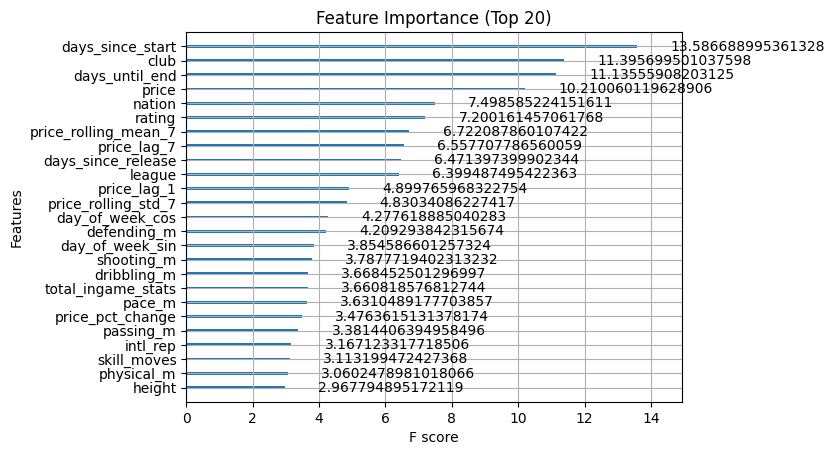

In [31]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_model, max_num_features=25, importance_type='gain')  # Show top 10 features
plt.title("Feature Importance (Top 20)")
plt.show()

In [32]:
results = best_model.evals_result()

# Plot training and validation loss
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.legend()
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("XGBoost Training and Validation Loss")
plt.show()


XGBoostError: No evaluation result, `eval_set` is not used during training.

In [33]:
# FC25 DATASET PRE_PROCESSING
df_25 = pd.read_csv('filtered_fc25_player_data.csv')
df_25.head()

df_25 = df_25.drop('foot', axis=1)
df_25 = df_25.drop('acceleration', axis=1)
df_25 = df_25.drop('sprint_speed', axis=1)
df_25 = df_25.drop('att_position', axis=1)
df_25 = df_25.drop('finishing', axis=1)
df_25 = df_25.drop('shot_power', axis=1)
df_25 = df_25.drop('long_shots', axis=1)
df_25 = df_25.drop('volleys', axis=1)
df_25 = df_25.drop('penalties', axis=1)
df_25 = df_25.drop('vision', axis=1)
df_25 = df_25.drop('crossing', axis=1)
df_25 = df_25.drop('fk_accuracy', axis=1)
df_25 = df_25.drop('short_pass', axis=1)
df_25 = df_25.drop('long_pass', axis=1)
df_25 = df_25.drop('curve', axis=1)
df_25 = df_25.drop('agility', axis=1)
df_25 = df_25.drop('balance', axis=1)
df_25 = df_25.drop('reactions', axis=1)
df_25 = df_25.drop('ball_control', axis=1)
df_25 = df_25.drop('dribbling', axis=1)
df_25 = df_25.drop('composure', axis=1)
df_25 = df_25.drop('interceptions', axis=1)
df_25 = df_25.drop('heading_acc', axis=1)
df_25 = df_25.drop('def_aware', axis=1)
df_25 = df_25.drop('stand_tackle', axis=1)
df_25 = df_25.drop('slide_tackle', axis=1)
df_25 = df_25.drop('jumping', axis=1)
df_25 = df_25.drop('stamina', axis=1)
df_25 = df_25.drop('strength', axis=1)
df_25 = df_25.drop('aggression', axis=1)
df_25 = df_25.drop('playstyles', axis=1)
df_25 = df_25.drop('weight', axis=1)
df_25 = df_25.drop('accelerate', axis=1)
df_25 = df_25.drop('body_type', axis=1)

# Ensure 'date' column is in datetime format
df_25['date'] = pd.to_datetime(df_25['date'])

# Get start and end dates of the game cycle
fc25_start_date = datetime.strptime("2024-09-20", "%Y-%m-%d")
fc25_end_date = datetime.strptime("2025-08-30", "%Y-%m-%d")

# Compute days_since_start and days_until_end based on FC24 game cycle
df_25['days_since_start'] = (df_25['date'] - fc25_start_date).dt.days
df_25['days_until_end'] = (fc25_end_date - df_25['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_25.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_25 = df_25.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_25['days_since_release'] = (df_25['date'] - df_25['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_25 = df_25.drop(columns=['release_date'])

# Remove rows with price = 0
df_25 = df_25[df_25['price'] > 0].reset_index(drop=True)

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_25)}")

# Step 2: Sort and Prepare Data
df_25['date'] = pd.to_datetime(df_25['date'])  # Ensure date is datetime
df_25 = df_25.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_25['intl_rep'] = df_25['intl_rep'].fillna(1)

# Create lag features
df_25['price_lag_1'] = df_25.groupby('card_id')['price'].shift(1)
df_25['price_lag_7'] = df_25.groupby('card_id')['price'].shift(7)

# Create rolling mean and std features
df_25['price_rolling_mean_7'] = df_25.groupby('card_id')['price'].rolling(7).mean().reset_index(level=0, drop=True)
df_25['price_rolling_std_7'] = df_25.groupby('card_id')['price'].rolling(7).std().reset_index(level=0, drop=True)

# Calculate percentage change from the previous day
df_25['price_pct_change'] = df_25.groupby('card_id')['price'].pct_change()

# Handle missing values for lag features
df_25['price_lag_1'] = df_25['price_lag_1'].fillna(df_25['price'])
df_25['price_lag_7'] = df_25['price_lag_7'].fillna(df_25['price'])

# Handle missing values for rolling features
df_25['price_rolling_mean_7'] = df_25['price_rolling_mean_7'].fillna(df_25['price'])
df_25['price_rolling_std_7'] = df_25['price_rolling_std_7'].fillna(0)

# Handle missing values for percentage change
df_25['price_pct_change'] = df_25['price_pct_change'].fillna(0)


Number of rows after removing 0 price: 198944


In [34]:
df_25.isnull().sum()

date                    0
price                   0
card_id                 0
rating                  0
skill_moves             0
weak_foot               0
pace_m                  0
shooting_m              0
passing_m               0
dribbling_m             0
defending_m             0
physical_m              0
height                  0
total_ingame_stats      0
nation                  0
league                  0
club                    0
intl_rep                0
days_since_start        0
days_until_end          0
days_since_release      0
price_lag_1             0
price_lag_7             0
price_rolling_mean_7    0
price_rolling_std_7     0
price_pct_change        0
dtype: int64

In [35]:
import numpy as np

# Add cyclic day of the week features
df_25['date'] = pd.to_datetime(df_25['date'])

# Extract day of the week as an integer (Monday=0, Sunday=6)
df_25['day_of_week'] = df_25['date'].dt.dayofweek

# Calculate cyclic features
df_25['day_of_week_sin'] = np.sin(2 * np.pi * df_25['day_of_week'] / 7)
df_25['day_of_week_cos'] = np.cos(2 * np.pi * df_25['day_of_week'] / 7)

# Drop 'day_of_week' as it is no longer needed
df_25 = df_25.drop(columns=['day_of_week'])

# Verify the new columns
df_25[['day_of_week_sin', 'day_of_week_cos']].head()

,day_of_week_sin,day_of_week_cos
0,-0.433884,-0.900969
1,-0.974928,-0.222521
2,-0.781831,0.623490
3,0.000000,1.000000
4,0.781831,0.623490


In [36]:
# Calculate Percent Change on Day 7
df_25['percent_change_7_days'] = ((df_25.groupby('card_id')['price'].shift(-7) - df_25['price']) /
                                  df_25['price']) * 100

# Create Classification Target
df_25['target'] = (df_25['percent_change_7_days'] > 0).astype(int)  # 1 for increase, 0 for decrease

# Drop rows where percent_change_7_days is NaN
df_25 = df_25.dropna(subset=['percent_change_7_days']).reset_index(drop=True)
df_25.isnull().sum()

# Remove rows where percent_change_7_days is greater than 110%
df_25 = df_25[df_25['percent_change_7_days'] <= 110].reset_index(drop=True)

# Remove all rows where rating is <= 83
df_25 = df_25[df_25['rating'] > 83].reset_index(drop=True)

# Verify the updated DataFrame
print(f"Number of rows after removal: {len(df_25)}")

# Specify categorical columns
categorical_cols = ['nation', 'league', 'club']

# Convert to category dtype
for col in categorical_cols:
    df_25[col] = df_25[col].astype('category')

Number of rows after removal: 36691


In [37]:
df_25.columns

Index(['date', 'price', 'card_id', 'rating', 'skill_moves', 'weak_foot',
       'pace_m', 'shooting_m', 'passing_m', 'dribbling_m', 'defending_m',
       'physical_m', 'height', 'total_ingame_stats', 'nation', 'league',
       'club', 'intl_rep', 'days_since_start', 'days_until_end',
       'days_since_release', 'price_lag_1', 'price_lag_7',
       'price_rolling_mean_7', 'price_rolling_std_7', 'price_pct_change',
       'day_of_week_sin', 'day_of_week_cos', 'percent_change_7_days',
       'target'],
      dtype='object')

In [38]:
# Ensure columns in df_25 are consistent with the training set
X_test_25 = df_25.drop(columns=['card_id', 'date', 'percent_change_7_days', 'target'])  # Features
y_test_25 = df_25['target']  # Binary target (1 for increase, 0 for decrease)

# Verify shapes of X_test_25 and y_test_25
print(f"Test set features shape: {X_test_25.shape}")
print(f"Test set target shape: {y_test_25.shape}")

Test set features shape: (36691, 26)
Test set target shape: (36691,)


In [39]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Make predictions on the test set
y_pred_25 = best_model.predict(X_test_25)
y_pred_proba_25 = best_model.predict_proba(X_test_25)[:, 1]  # Probabilities for class 1 (increase)

# Evaluate the performance
accuracy_25 = accuracy_score(y_test_25, y_pred_25)
auc_roc_25 = roc_auc_score(y_test_25, y_pred_proba_25)

print(f"Test Set Accuracy: {accuracy_25:.4f}")
print(f"Test Set AUC-ROC: {auc_roc_25:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_25, y_pred_25))

Test Set Accuracy: 0.6179
Test Set AUC-ROC: 0.6420

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69     21943
           1       0.53      0.46      0.49     14748

    accuracy                           0.62     36691
   macro avg       0.60      0.59      0.59     36691
weighted avg       0.61      0.62      0.61     36691

